## Creating an image tiling with NumPy and PIL

I needed a way to create a KML overlay for large areas. Just outputting a matplotlib figure and writing a kml overlay wasn't working for me because the image would get distorted. In my development environment I don't have access to the matplotlib basemap or the liesure to download whatever software I need on the production system. So to save myself some hassle I wanted to create a kml overlay and use image tiles to impress more coordinate information on the result.

## Scikit-Learn exmaple data
I'm using the [sklearn kernel density](http://scikit-learn.org/stable/auto_examples/neighbors/plot_species_kde.html) example because everyone should have access to the data and it runs fairly quick. I took out the code to iterate over species because I just want the one tile. Extendiding to multiple overlays is possible and only requires a slight modification to the output kml.

In [1]:
import os
import numpy as np
from PIL import Image
from zipfile import ZipFile
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from sklearn.datasets import fetch_species_distributions
from sklearn.datasets.species_distributions import construct_grids

In [2]:
%matplotlib inline

In [3]:
# The SKLearn code throws a warning
import warnings
warnings.filterwarnings('ignore')

## Example SKLearn Code

I also added the corner points to the plot so you can see that the combination of lats and longs cover the output extent and can be used for the eventual overlay extent. 

If you're familiar with matplotlib then you probably know that you can chunk up a plot with the plt.axis method, but then you'll run into issues with whitespace which I couldn't get around plus the matplotlib GUI would flash on the screen. 

 - computing KDE in spherical coordinates


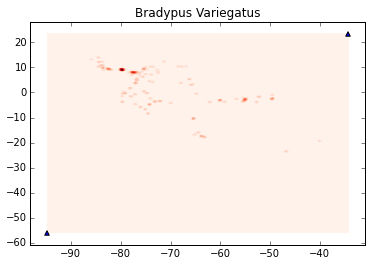

In [4]:
###### # Get matrices/arrays of species IDs and locations
data = fetch_species_distributions()
species_names = ['Bradypus Variegatus', 'Microryzomys Minutus']

Xtrain = np.deg2rad(np.vstack([data['train']['dd lat'],
                    data['train']['dd long']]).T)
ytrain = np.array([d.decode('ascii').startswith('micro')
                  for d in data['train']['species']], dtype='int')

# Set up the data grid for the contour plot
xgrid, ygrid = construct_grids(data)
X, Y = np.meshgrid(xgrid[::5], ygrid[::5][::-1])

xy = np.vstack([Y.ravel(), X.ravel()]).T
xy = np.deg2rad(xy)

i = 0

# Plot map of South America with distributions of each species
# construct a kernel density estimate of the distribution
print(" - computing KDE in spherical coordinates")
kde = KernelDensity(bandwidth=0.004, metric='haversine',
                    kernel='gaussian', algorithm='ball_tree')
kde.fit(Xtrain[ytrain == i])

# evaluate only on the land: -9999 indicates ocean
# Z = -9999 + np.zeros(land_mask.shape[0])
Z = np.exp(kde.score_samples(xy))
Z = Z.reshape(X.shape)

# plot contours of the density
levels = np.linspace(0, Z.max(), 25)
plt.contourf(X, Y, Z, levels=levels, cmap=plt.cm.Reds)
plt.scatter([X.max(), X.min()], [Y.max(), Y.min()], marker="^")
plt.title(species_names[i])

plt.show()


## Step 1. Scale the array result
The values out of kernel density will vary depending on your data. For us to use the matplotlib color maps, we need to first scale from 0-1 which is easy enough below.

In [5]:
def float_to_pixel(array):
    return ((array - array.min()) * (1./(array.max() - array.min())))

In [6]:
scaled_outputs = float_to_pixel(Z)

## Step 2. 

For manipulating jpg and png images, the values need to be between 0-255. After scaling the values between 0-1 we mulitply by 255 to get pixels in the range we want and conver to usigned 8 bit integers. Now we're ready to tile.

In [7]:
img=np.uint8(plt.cm.Reds(scaled_outputs) * 255)

## Plotting Original Data
We want to verify that the eventual output lines up correctly so using these few lines we can create a KML with the training data. No need for a some extra library, just a few tags.

In [8]:
header = """<?xml version="1.0" encoding="UTF-8"?>
<kml xmlns="http://www.opengis.net/kml/2.2">
<Document>
<Folder>
<name>Points</name>
"""
point_format = """
  <Placemark>
    <name></name>
    <description></description>
    <Point>
      <coordinates>{lat},{lon},0</coordinates>
    </Point>
  </Placemark>
"""
with open("species.kml", 'w') as target:
    samples = np.rad2deg(Xtrain[ytrain==i])
    target.write(header)
    for idx in xrange(samples.shape[0]):
        lon, lat = samples[idx]
        target.write(point_format.format(lat=lat, lon=lon))
    target.write("</Folder></Document></kml>")

## Step 3
Gather some basic image statistics. We'll use these later to map pixels to a geographic area.

In [9]:
rows, cols, channels = img.shape
min_lon, max_lon = X.min(), X.max()
min_lat, max_lat = Y.min(), Y.max()
ave_width = (max_lon - min_lon)/cols
ave_height = (max_lat - min_lat)/rows

## Step 4
The overlay template. Pulled from right from the [docs](https://developers.google.com/kml/documentation/kml_tut).

In [10]:
header = """<?xml version="1.0" encoding="UTF-8"?>
<kml xmlns="http://www.opengis.net/kml/2.2">
  <Folder>
    <name>Species Density</name>
    <description>Examples of ground overlays</description>"""
overlay = """<GroundOverlay>
      <name>tile_no</name>
      <description></description>
      <Icon>
        <href>{tile}</href>
      </Icon>
      <LatLonBox>
        <north>{north}</north>
        <south>{south}</south>
        <east>{east}</east>
        <west>{west}</west>
        <rotation>0</rotation>
      </LatLonBox>
    </GroundOverlay>"""
footer= """  </Folder>
</kml>"""

## Step 5
Making the overlay. Thre is a lot going on here but the essential idea is that we're going through the original array in chunks (see tile size below), cutting out smaller squares into a new array and writing them to disk along with an overlay entry. 

In [11]:
tile_size = 30

# We start in the upper left so northern-most latitude and east-most longitude
current_lat = max_lat
current_lon = min_lon

# for tile files
tile_no = 0

# Make the output folder if it doesn't already exist
if not os.path.exists('density'):
    os.mkdir('density')

# New kml file. All items can be placed in a folder, zipped, and change the extension to kmz. GE will recognize it
with open("density/overlay.kml", 'w') as target:
    
    # kml header info from above 
    target.write(header)
    
    # add this extra logic in the range to max sure we include all image cells
    for row in xrange(0, rows + (tile_size - (rows % tile_size) + 1), tile_size):
        for col in xrange(0, cols + (tile_size - (cols % tile_size) + 1), tile_size):
            
            # Create a blank array to store a tile
            array = np.zeros(shape=(tile_size, tile_size, channels), dtype=img.dtype)
            
            # get the step/tile size
            stop_col = col + tile_size
            stop_row = row + tile_size
            
            # Copy the original image slice
            im_slice = img[row:stop_row, col:stop_col, :].copy()
            
            # get the shape. We'll use these for indexing 
            # so we don't get index errors 
            row_slice, col_slice, _ = im_slice.shape
            
            # cut out the data
            array[:row_slice,:col_slice,:] = im_slice
            
            # Convery to an image with PIL
            out_img = Image.fromarray(array)
            
            # Save with a unique name
            tile = os.path.abspath("density/tile_{0}.png".format(tile_no))
            out_img.save(tile)
            
            # Caluclate the bounding box using the average height and average column width
            north = max_lat - (row * ave_height)
            south = max_lat - ((stop_row) * ave_height)
            east = min_lon + (col * ave_width)
            west = min_lon + (stop_col * ave_width)
            
            # Write the overlay information 
            target.write(overlay.format(tile=tile, north=north, 
                                        south=south, east=east, west=west))
            
            # increment the tileid
            tile_no += 1
        
        # increment the latitude for the next row. Subtract becasue
        # We start in the top left
        current_lat = current_lat - (ave_height * row)
    
    # wrap it up with the footer
    target.write(footer)

## Optional: Create a KMZ

A KMZ is just a zipfile with a kml and supporting files. Just change the file extension.

In [12]:
with ZipFile("density.kmz", 'w') as archive:
    for file_name in os.listdir('density'):
        archive.write(os.path.join('density', file_name))